# Time Series Forecast

## Preparação do dataset

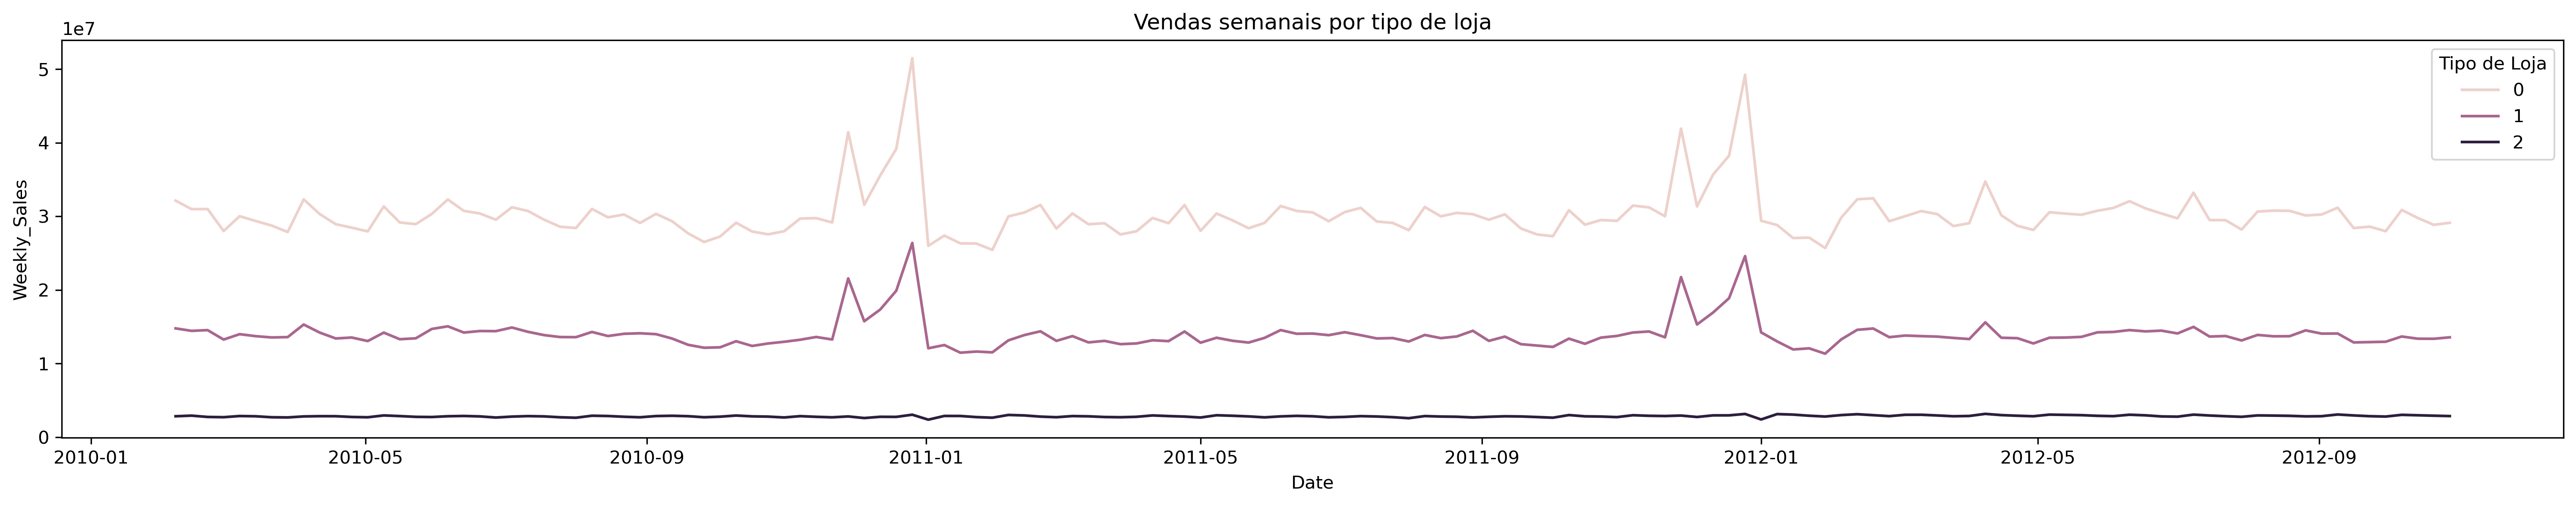

In [299]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Bibliotecas
--------------------------------------------------------------------------------------------------------------------
'''

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from warnings import filterwarnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/WalmartSalesForecast/Arquivos CSV")

'''
--------------------------------------------------------------------------------------------------------------------
-------- Importando e editando o dataframe
--------------------------------------------------------------------------------------------------------------------
'''

train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')

# Editando o df de treino

# Eliminando, pois essa coluna já existe em treino e teste
features = features.drop(columns=['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

# Juntando as colunas de features dos arquivos Stores e Features
train_merge = pd.merge(train, stores, on='Store', how='left')
train_merge = pd.merge(train_merge, features, on=['Store', 'Date'], how='left')

# Editando o df
train_merge = train_merge.set_index('Date')
train_merge.index = pd.to_datetime(train_merge.index)

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(train_merge['Type'].unique()):
    transf[valor] = i

train_merge['Type'] = train_merge['Type'].map(transf)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Timeline
--------------------------------------------------------------------------------------------------------------------
'''

sales_by_type_weekly = train_merge.groupby('Type').resample('W')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(20, 4), dpi=300)
sns.lineplot(data=sales_by_type_weekly, x='Date', y='Weekly_Sales', hue='Type')
plt.title('Vendas semanais por tipo de loja')
plt.legend(title='Tipo de Loja')
plt.tight_layout()
plt.show()

In [300]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Separando dataset por departamento
--------------------------------------------------------------------------------------------------------------------
'''

dept1 = train_merge[train_merge['Dept'] == 1]
dept1 = dept1.drop(columns='Dept')

'''
--------------------------------------------------------------------------------------------------------------------
-------- Gerando Lags
-------- Começando do lag 6 pq quero prever 6 semanas no futuro
--------------------------------------------------------------------------------------------------------------------
'''

for i in range(6, 13):
    dept1[f'lag{i}'] = dept1.groupby('Store')['Weekly_Sales'].shift(i)

# Eliminando as linhas com NaN
dept1 = dept1.dropna()

## XGB default com todas as colunas

In [301]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- XGBRegressor default (com todas as colunas)
--------------------------------------------------------------------------------------------------------------------
'''

X = dept1.drop(columns='Weekly_Sales')
y = dept1['Weekly_Sales']

X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

# Validando o corte das datas cima
if X_train.index.min() == y_train.index.min() and X_train.index.max() == y_train.index.max() and X_test.index.min() == y_test.index.min() and X_test.index.max() == y_test.index.max():
    print("Modelo treinado com sucesso.")
else:
    print("Problema com as datas de treino e teste. Verificar!")

model = xgb.XGBRegressor(verbosity=1)
model.fit(X_train, y_train)

Modelo treinado com sucesso.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [302]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Comparação dos valores reais X valores preditos 
--------------------------------------------------------------------------------------------------------------------
'''

predictions = model.predict(X_test)

df_resultados = pd.DataFrame({'Data': X_test.index, 'Valor_Real': y_test, 'Valor_Predito': predictions})
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.drop(columns=['Date'])
df_resultados['Data'] = pd.to_datetime(df_resultados['Data'])

df_resultados = df_resultados.groupby('Data')[['Valor_Real', 'Valor_Predito']].sum().reset_index()
df_resultados['Valor_Predito'] = df_resultados['Valor_Predito'].round(decimals=2)

df_resultados.sort_values(by='Data', inplace=True)

df_resultados.head()

,Data,Valor_Real,Valor_Predito
0,2012-09-21,740105.84,737888.1875
1,2012-09-28,754344.66,761921.2500
2,2012-10-05,855362.83,778620.0000
3,2012-10-12,936707.78,869909.1250
4,2012-10-19,1037182.46,899342.1875


In [303]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Erros
--------------------------------------------------------------------------------------------------------------------
'''
error = np.sum(predictions - y_test).round(2)

rmse = mean_squared_error(y_test, predictions, squared=False)

mae = mean_absolute_error(y_test, predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.DataFrame({'Teste': ['XGBRegressor Default All Columns'],
                           'Erro Total': [error],
                           'RMSE': [rmse],
                           'MAE': [mae],
                           'MAPE (%)': [mape]
                            })


# Exibir o DataFrame
results_df.head()

,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default All Columns,-677289.13,5931.028434,3757.730719,16.940999


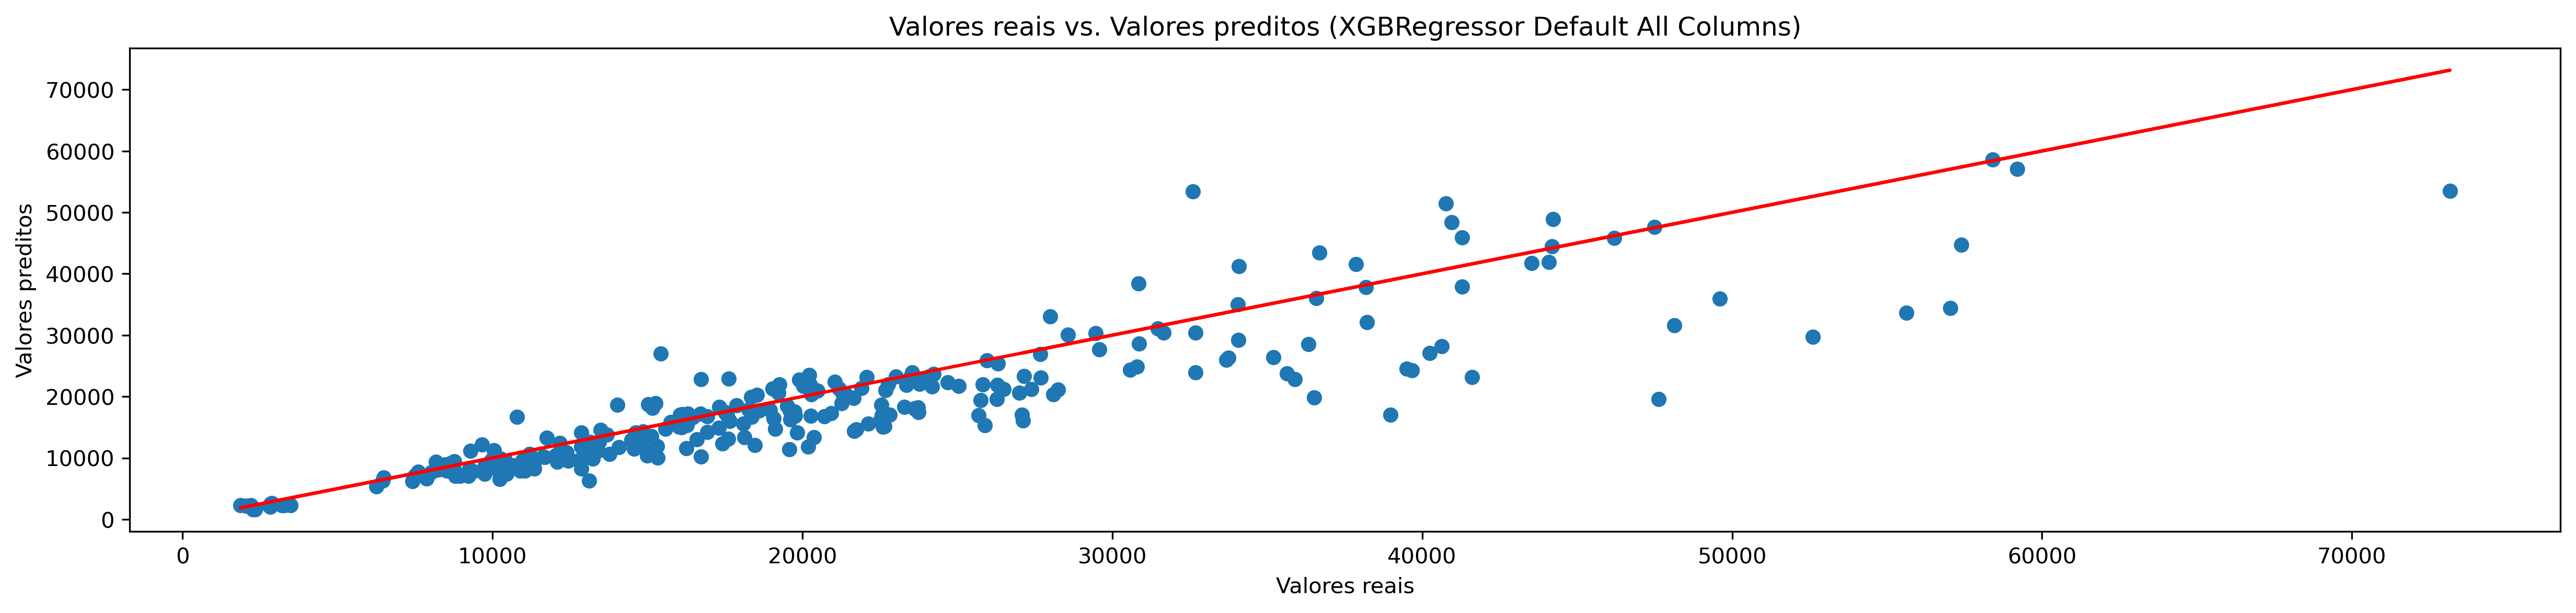

In [304]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(20, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos (XGBRegressor Default All Columns)')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()

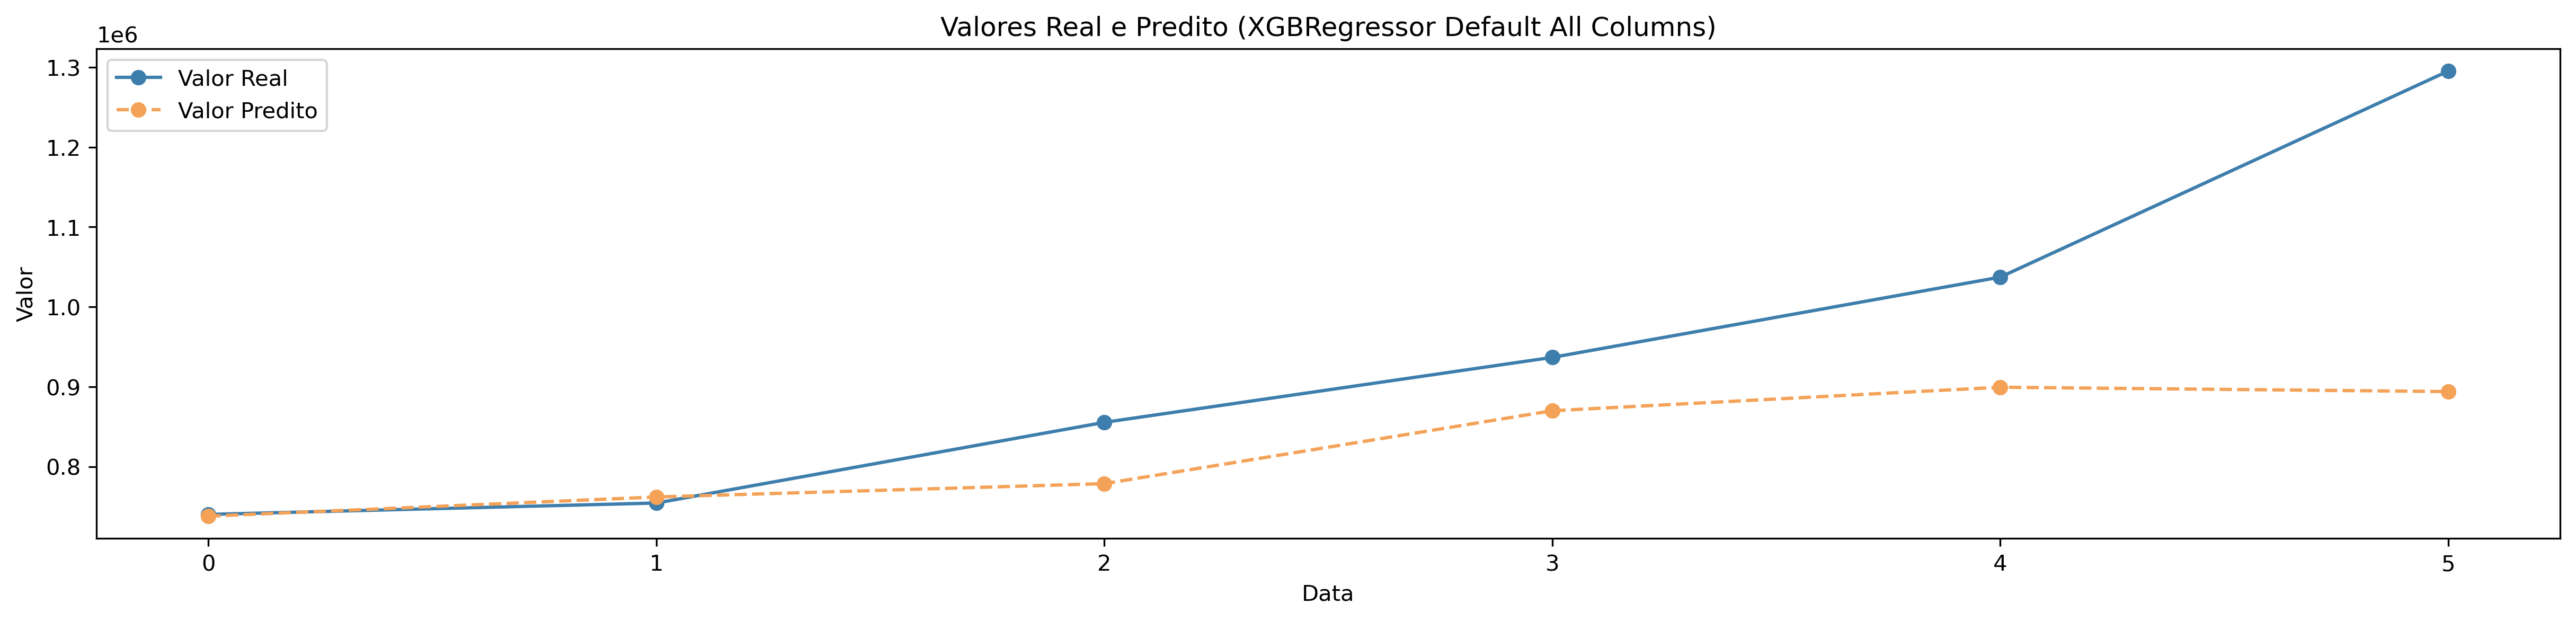

In [305]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras
--------------------------------------------------------------------------------------------------------------------
'''

# Coluna de diferença
df_resultados['Diferenca'] = df_resultados['Valor_Real'] - df_resultados['Valor_Predito']

plt.figure(figsize=(20, 4), dpi=300)
plt.plot(df_resultados.index, df_resultados['Valor_Real'], color='#3e7eac', label='Valor Real', marker='o')
plt.plot(df_resultados.index, df_resultados['Valor_Predito'], color='#f4a258', label='Valor Predito', marker='o', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real e Predito (XGBRegressor Default All Columns)')
plt.legend()
plt.show()

## XGB default colunas Lasso

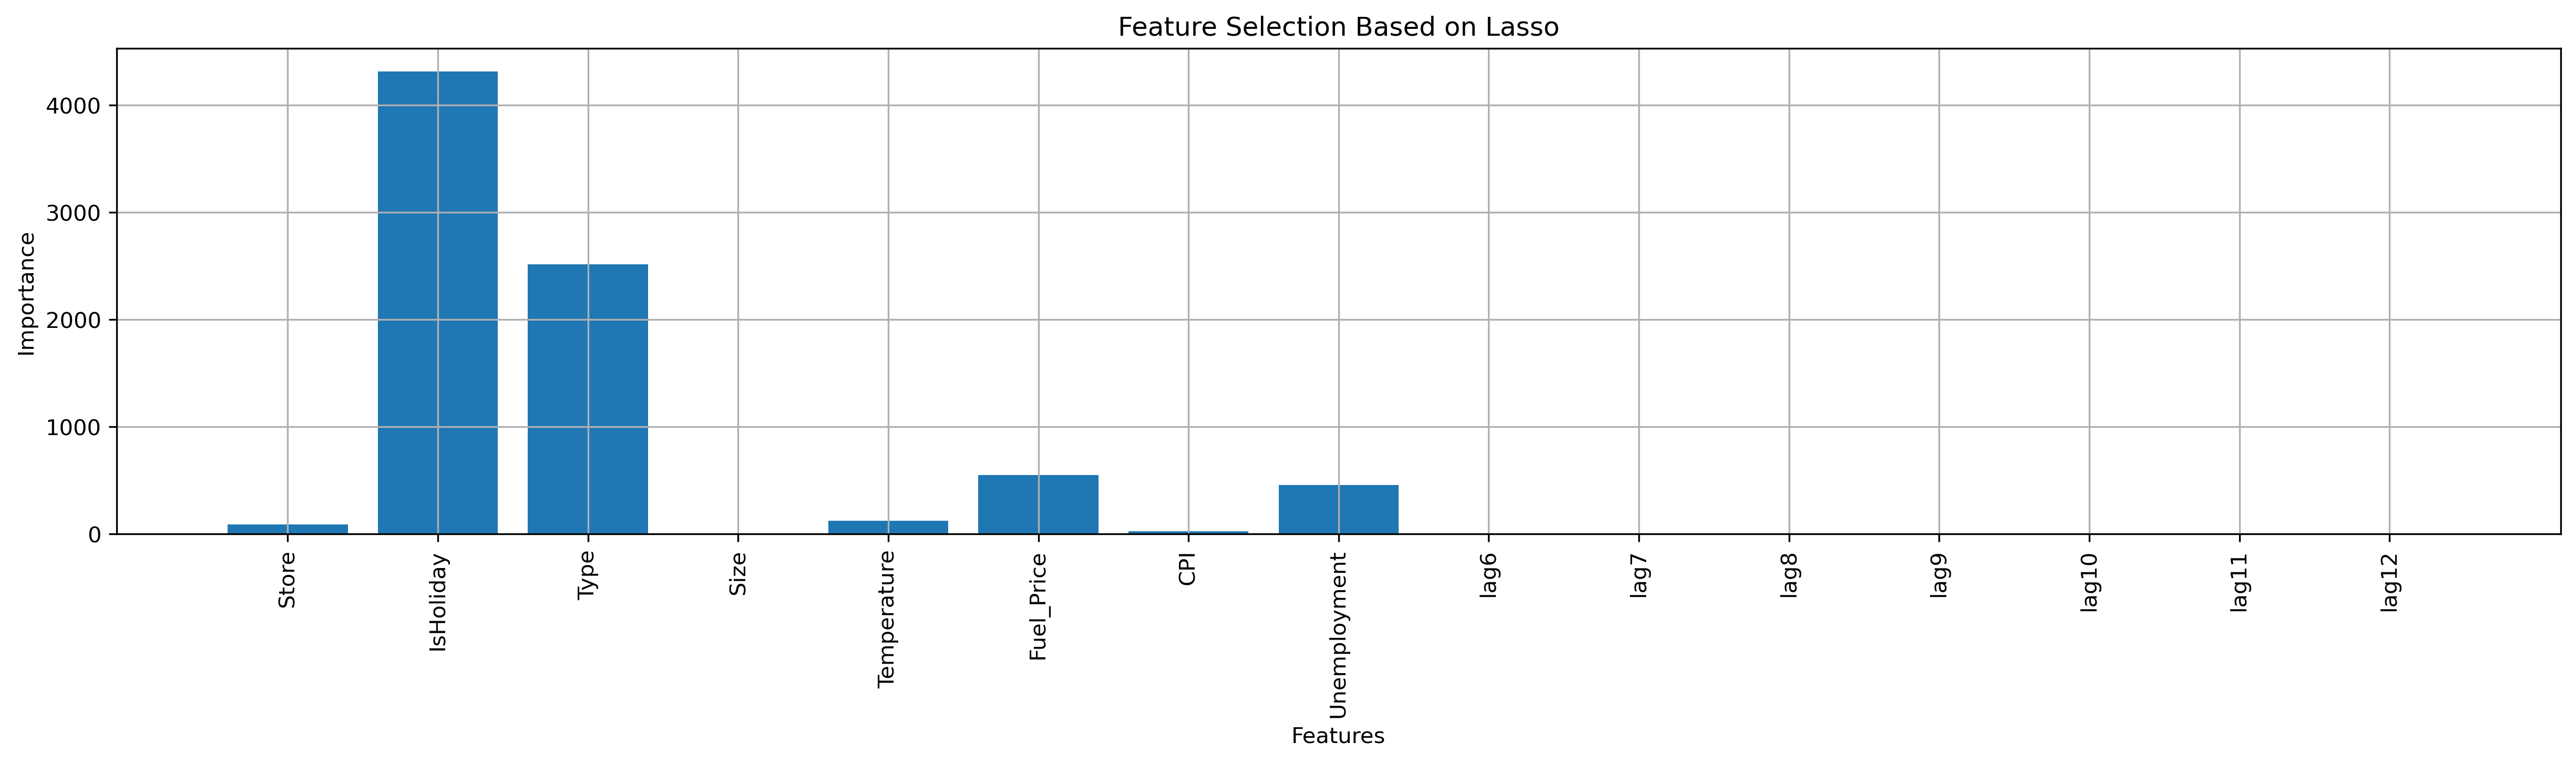

In [306]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Analisando feature importance
--------------------------------------------------------------------------------------------------------------------
'''

dept1_dropna = dept1.dropna()

# Separando as features do target
X = dept1_dropna.drop(columns='Weekly_Sales') 
y = dept1_dropna['Weekly_Sales']

col_names = X.columns

from sklearn.linear_model import Lasso

# Lasso
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

lasso = Lasso(alpha=0.00001)
lasso.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso_coef = np.abs(lasso.coef_)

# plotting the Column Names and Importance of Columns. 
plt.figure(figsize=(20, 4), dpi=300)
plt.bar(col_names, lasso_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Filtrando as features com coeficiente maior que 0.01
filtered_columns = [name for name, coef in zip(col_names, lasso_coef) if coef > 0.01]
colunas = filtered_columns

In [307]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Definindo o dataset apenas com as colunas que Lasso classificou como boas
--------------------------------------------------------------------------------------------------------------------
'''

filtered_columns = [name for name, coef in zip(col_names, lasso_coef) if coef > 0.05]
colunas = filtered_columns + ['Weekly_Sales'] # Devolvendo a coluna target para deixar que o X e y separe-os depois

dept1 = dept1[colunas]

print(colunas)

['Store', 'IsHoliday', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'lag6', 'lag7', 'lag8', 'lag10', 'Weekly_Sales']


In [308]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- XGBRegressor default
--------------------------------------------------------------------------------------------------------------------
'''

X = dept1.drop(columns='Weekly_Sales')
y = dept1['Weekly_Sales']

X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

# Validando o corte das datas cima
if X_train.index.min() == y_train.index.min() and X_train.index.max() == y_train.index.max() and X_test.index.min() == y_test.index.min() and X_test.index.max() == y_test.index.max():
    print("Modelo treinado com sucesso.")
else:
    print("Problema com as datas de treino e teste. Verificar!")

model = xgb.XGBRegressor(verbosity=1)
model.fit(X_train, y_train)

Modelo treinado com sucesso.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [309]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Comparação dos valores reais X valores preditos 
--------------------------------------------------------------------------------------------------------------------
'''

predictions = model.predict(X_test)

df_resultados = pd.DataFrame({'Data': X_test.index, 'Valor_Real': y_test, 'Valor_Predito': predictions})
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.drop(columns=['Date'])
df_resultados['Data'] = pd.to_datetime(df_resultados['Data'])

df_resultados = df_resultados.groupby('Data')[['Valor_Real', 'Valor_Predito']].sum().reset_index()
df_resultados['Valor_Predito'] = df_resultados['Valor_Predito'].round(decimals=2)

df_resultados.sort_values(by='Data', inplace=True)

df_resultados.head()

,Data,Valor_Real,Valor_Predito
0,2012-09-21,740105.84,719927.0625
1,2012-09-28,754344.66,696267.9375
2,2012-10-05,855362.83,740578.8750
3,2012-10-12,936707.78,815243.2500
4,2012-10-19,1037182.46,848733.8125


In [310]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Erros
--------------------------------------------------------------------------------------------------------------------
'''
error = np.sum(predictions - y_test).round(2)

rmse = mean_squared_error(y_test, predictions, squared=False)

mae = mean_absolute_error(y_test, predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.concat([results_df, pd.DataFrame({'Teste': ['XGBRegressor Default Lasso'],
                                                    'Erro Total': [error],
                                                    'RMSE': [rmse],
                                                    'MAE': [mae],
                                                    'MAPE (%)': [mape]
                                                      })])


# Exibir o DataFrame
results_df.head()

,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default All Columns,-677289.13,5931.028434,3757.730719,16.940999
0,XGBRegressor Default Lasso,-917658.58,5965.231190,4022.450872,18.408869


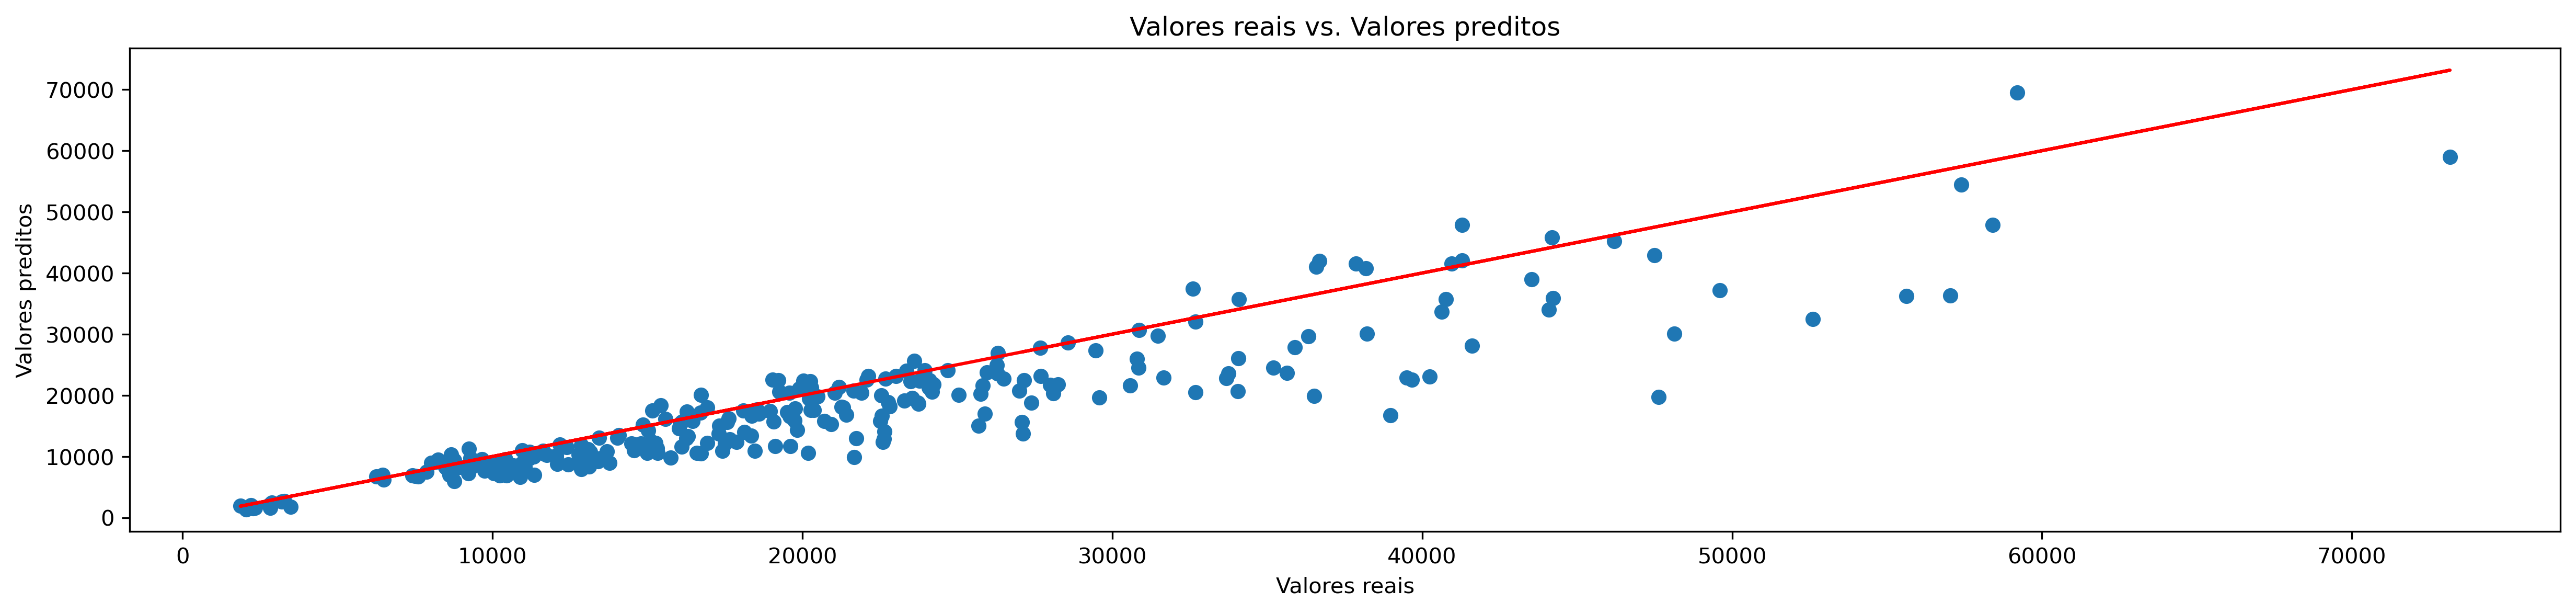

In [311]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(20, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()

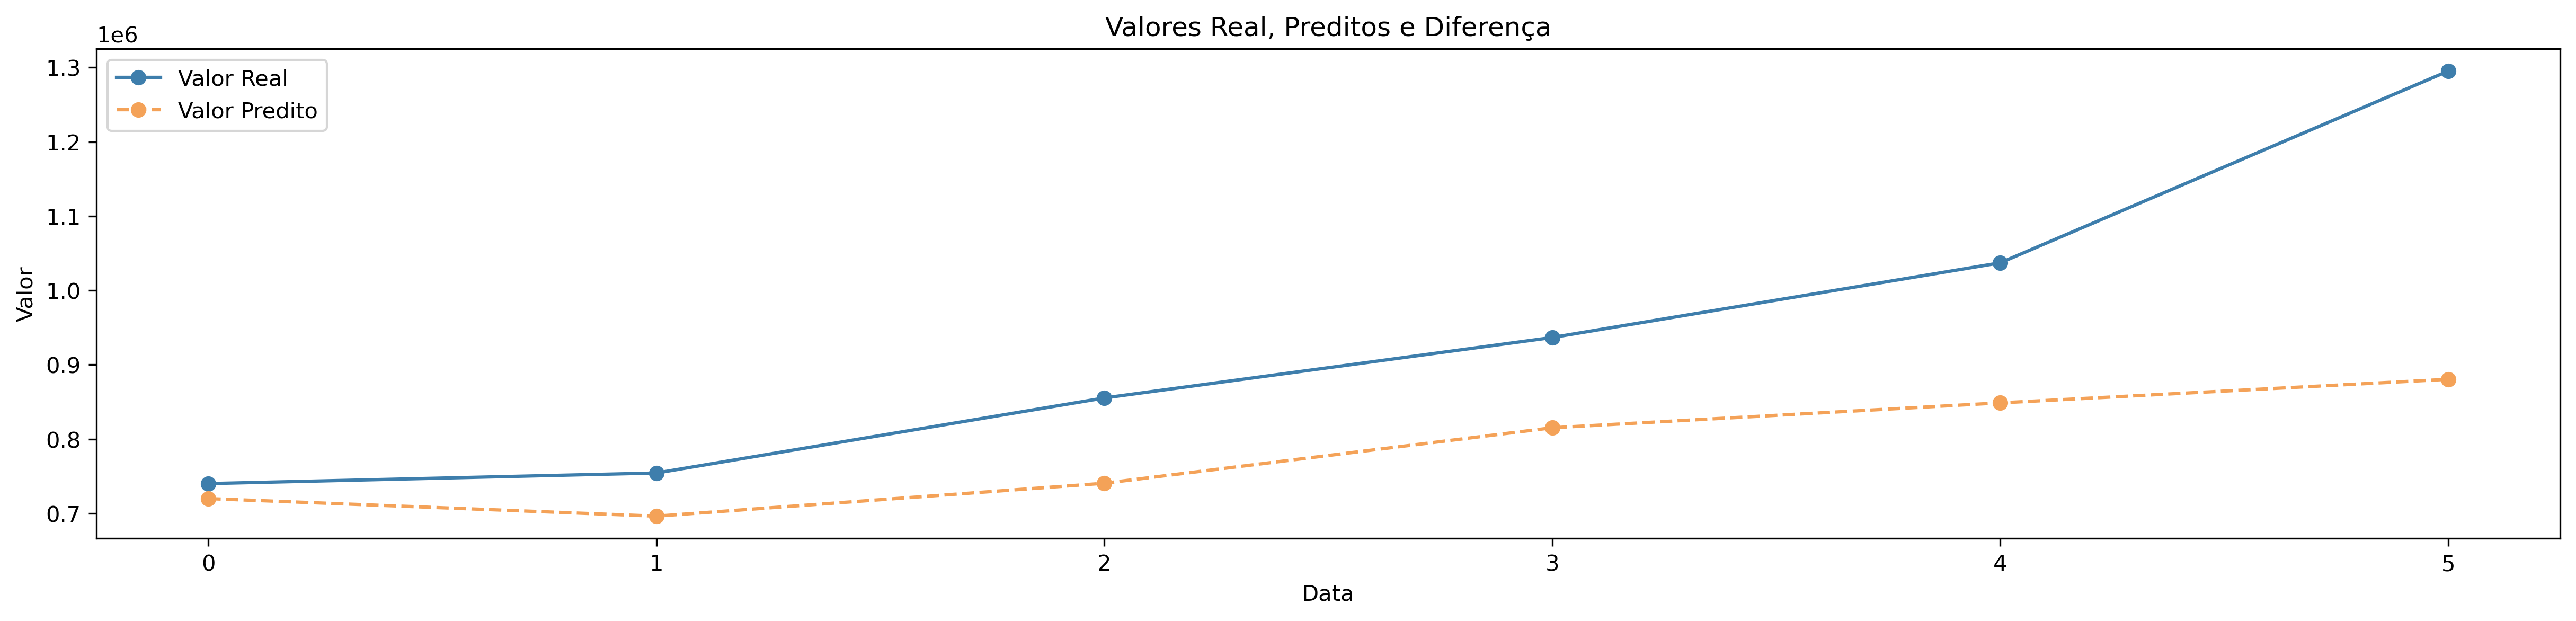

In [312]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras
--------------------------------------------------------------------------------------------------------------------
'''

# Coluna de diferença
df_resultados['Diferenca'] = df_resultados['Valor_Real'] - df_resultados['Valor_Predito']

plt.figure(figsize=(20, 4), dpi=300)
plt.plot(df_resultados.index, df_resultados['Valor_Real'], color='#3e7eac', label='Valor Real', marker='o')
plt.plot(df_resultados.index, df_resultados['Valor_Predito'], color='#f4a258', label='Valor Predito', marker='o', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real, Preditos e Diferença')
plt.legend()
plt.show()

## Aplicando resultado do modelo para datas no futuro

Aqui minha intenção é deixar salvo como a projeção deve ser aplicada a um dataset do qual não se tem os resultados do target, como será quando o modelo escolhido estiver em produção.

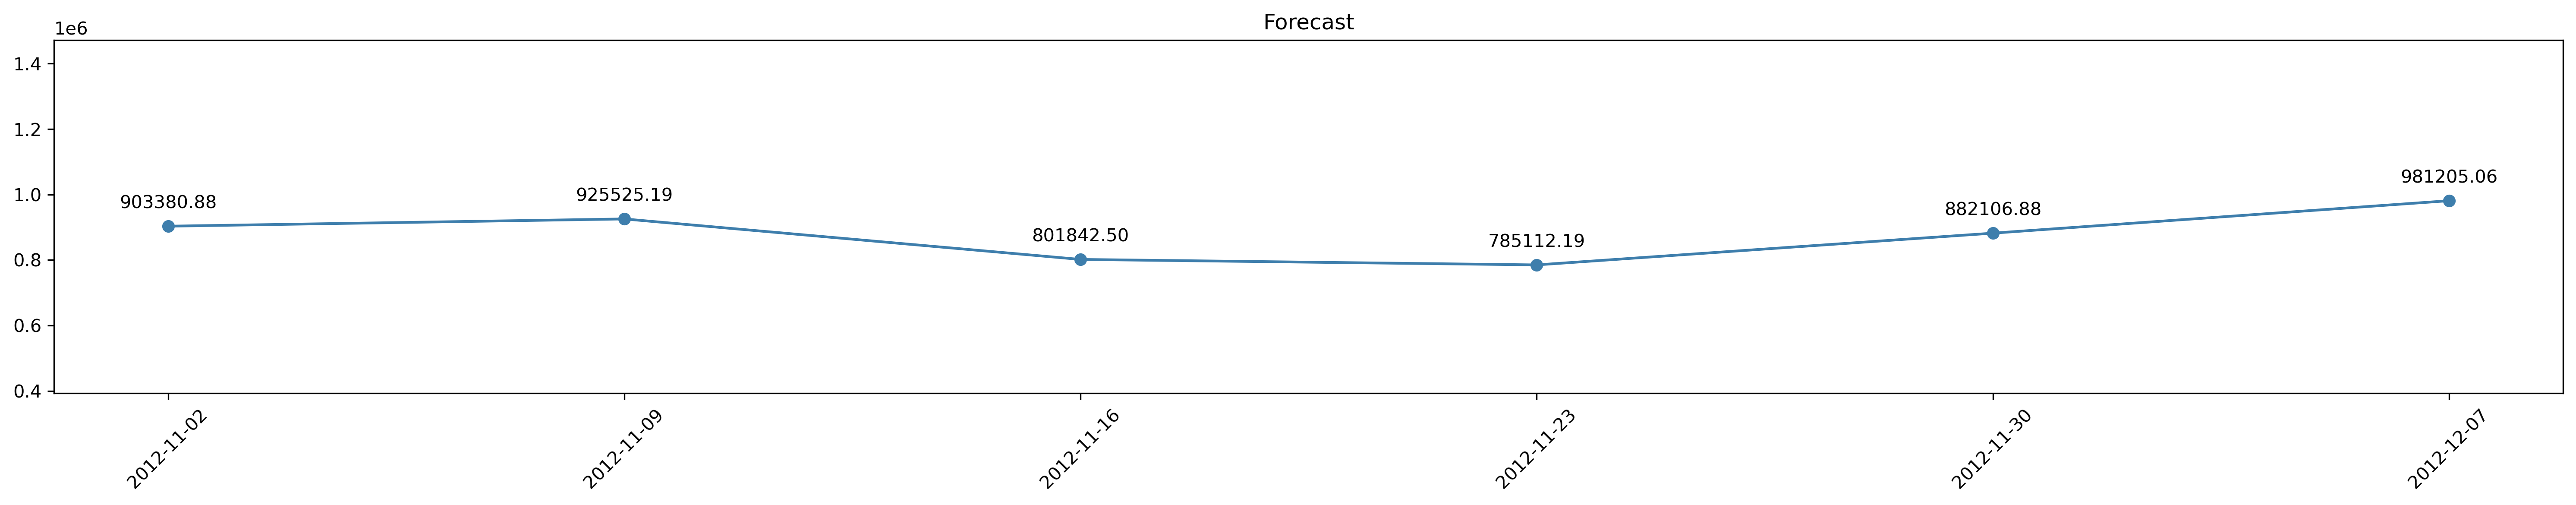

In [313]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Previsão para valores de datas futuras
--------------------------------------------------------------------------------------------------------------------
'''

# Adicionar a coluna de Weekly_Sales no dataset de teste para ficar igual ao de treino
# O Range de previsão pré definido por mim foram 6 semanas do futuro, sendo de 02/11/2012 até 07/12/2012
data_inicio = '2012-11-02'
data_fim = '2012-12-07'
test = test[(test['Date'] >= data_inicio) & (test['Date'] <= data_fim)]
test['Weekly_Sales'] = np.nan

'''
--------------------------------------------------------------------------------------------------------------------
-------- Transformando o dataset de test (futuro) no mesmo padrão do utilizado no modelo
--------------------------------------------------------------------------------------------------------------------
'''

# Juntando os dois dataframes para aplicar todas as alterações feitas lá em cima, para 
# deixá-lo no mesmo padrão do utilizado no treino do modelo e conseguirmos prever os valores que não temos
df_combined = pd.concat([test, train])

# Juntando as colunas de features dos arquivos Stores e Features
test_merge = pd.merge(df_combined, stores, on='Store', how='left')
test_merge = pd.merge(test_merge, features, on=['Store', 'Date'], how='left')

# Index
test_merge['Date'] = pd.to_datetime(test_merge['Date'])
test_merge = test_merge.sort_values(by=['Store', 'Date'])
test_merge = test_merge.set_index('Date')

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(test_merge['Type'].unique()):
    transf[valor] = i

test_merge['Type'] = test_merge['Type'].map(transf)

dept1_forecast = test_merge[test_merge['Dept'] == 1]
dept1_forecast = dept1_forecast.drop(columns='Dept')

# Criando as lags
for i in range(6, 13):
    dept1_forecast[f'lag{i}'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(i)

# Separando somente as colunas necessários igualmente utilizadas para treinar o modelo
dept1_forecast = dept1_forecast[colunas].drop(columns='Weekly_Sales')

'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando o modelo para datas que não temos os valores de vendas
--------------------------------------------------------------------------------------------------------------------
'''

X_forecast = dept1_forecast[dept1_forecast.index >= '2012-11-02']

forecast = model.predict(X_forecast)

df_forecast = pd.DataFrame({'Date': X_forecast.index, 'Store': X_forecast['Store'], 'Forecast': forecast})
df_forecast.reset_index(drop=True, inplace=True)
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

forecast_groupby_date = df_forecast.groupby('Date')['Forecast'].sum().reset_index()
forecast_groupby_date_store = df_forecast.groupby(['Store', 'Date'])['Forecast'].sum().reset_index()

# Plotando datas futuas
unique_dates = forecast_groupby_date['Date'].unique()

plt.figure(figsize=(20, 4), dpi=300)
plt.plot(forecast_groupby_date['Date'], forecast_groupby_date['Forecast'], marker='o', linestyle='-', color='#3e7eac')

for x, y in zip(forecast_groupby_date['Date'], forecast_groupby_date['Forecast']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Forecast')
plt.ylim(bottom=forecast_groupby_date['Forecast'].min() * 0.5)
plt.ylim(top=forecast_groupby_date['Forecast'].max() * 1.5)

# Defina apenas as datas únicas como rótulos do eixo X
plt.xticks(unique_dates, rotation=45)

plt.tight_layout()
plt.show()

# Hiperparemetros

In [314]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando Optuna para testar hiperparâmetros
--------------------------------------------------------------------------------------------------------------------
'''

import optuna

# Não exibir os logs do optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

X = dept1.drop(columns='Weekly_Sales')
y = dept1['Weekly_Sales']

X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

def objective(trial):
    
    # Espaço de hiperparâmetros para tunar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400), # quantidade de arvores 
        'max_depth': trial.suggest_int('max_depth', 3, 20), # profundidade da arvore
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3), # a cada iteração ele tenta diminuir o erro, e o intervalo indicado é o que eu espero
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0), # porcentagem de amostras que eu quero usar
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0), # porcentagem de colunas que eu quero usar
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1), # regularização L1 (diminuir overfitting)
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1), # regularização L2 (diminuir overfitting)
    }
    
    # Modelo
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
    
    # Predição e cálculo do RMSE
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

# Criando o estudo
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Melhores parâmetros
print('Best trial:', study.best_trial.params)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando os hipérparâmetros encontrados
--------------------------------------------------------------------------------------------------------------------
'''

model = xgb.XGBRegressor(**study.best_trial.params)
model.fit(X_train, y_train)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Comparação dos valores reais X valores preditos 
--------------------------------------------------------------------------------------------------------------------
'''
predictions = model.predict(X_test)

df_resultados = pd.DataFrame({'Data': X_test.index, 'Valor_Real': y_test, 'Valor_Predito': predictions})
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.drop(columns=['Date'])
df_resultados['Data'] = pd.to_datetime(df_resultados['Data'])

df_resultados = df_resultados.groupby('Data')[['Valor_Real', 'Valor_Predito']].sum().reset_index()
df_resultados['Valor_Predito'] = df_resultados['Valor_Predito'].round(decimals=2)

df_resultados.sort_values(by='Data', inplace=True)

df_resultados.head()

Best trial: {'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.017475623799739905, 'subsample': 0.9571153124720654, 'colsample_bytree': 0.736111205262732, 'reg_alpha': 0.00020804540375789283, 'reg_lambda': 0.00044566746799652886}


,Data,Valor_Real,Valor_Predito
0,2012-09-21,740105.84,763601.0625
1,2012-09-28,754344.66,733932.1875
2,2012-10-05,855362.83,780141.0625
3,2012-10-12,936707.78,886622.7500
4,2012-10-19,1037182.46,884200.1875


In [315]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Erros
--------------------------------------------------------------------------------------------------------------------
'''
error = np.sum(predictions - y_test).round(2)

rmse = mean_squared_error(y_test, predictions, squared=False)

mae = mean_absolute_error(y_test, predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.concat([results_df, pd.DataFrame({'Teste': ['XGBRegressor Optuna'],
                                                    'Erro Total': [error],
                                                    'RMSE': [rmse],
                                                    'MAE': [mae],
                                                    'MAPE (%)': [mape]
                                                      })])


# Exibir o DataFrame
results_df.head()

,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default All Columns,-677289.13,5931.028434,3757.730719,16.940999
0,XGBRegressor Default Lasso,-917658.58,5965.231190,4022.450872,18.408869
0,XGBRegressor Optuna,-660570.73,5484.720608,3362.980944,14.388461


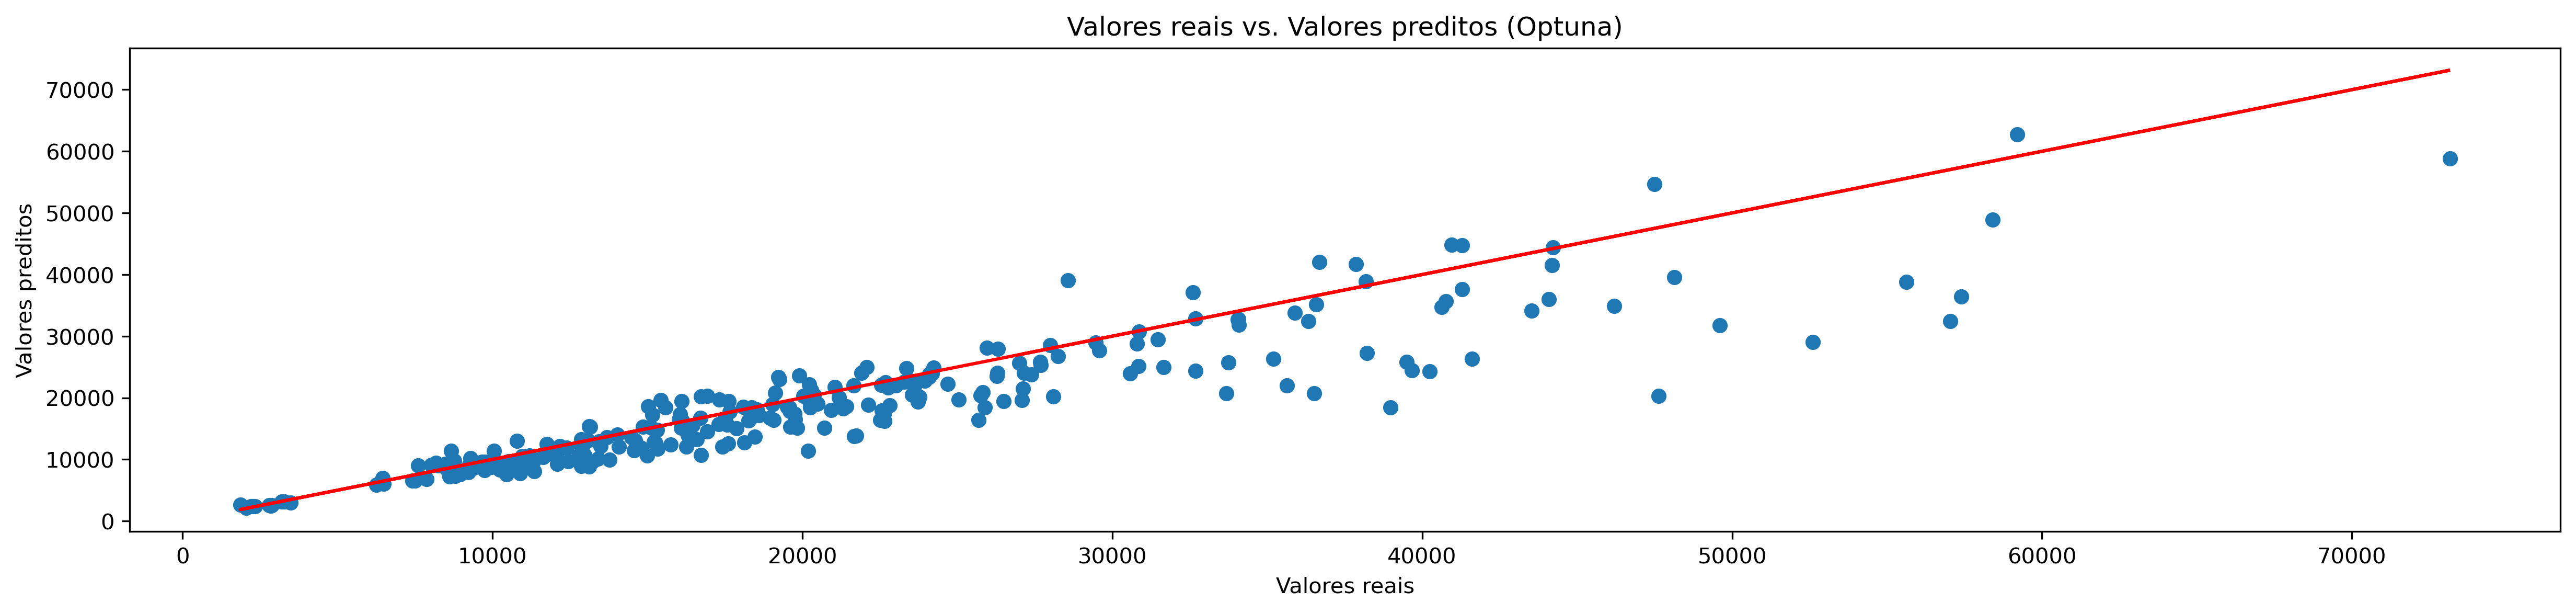

In [316]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(20, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos (Optuna)')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()

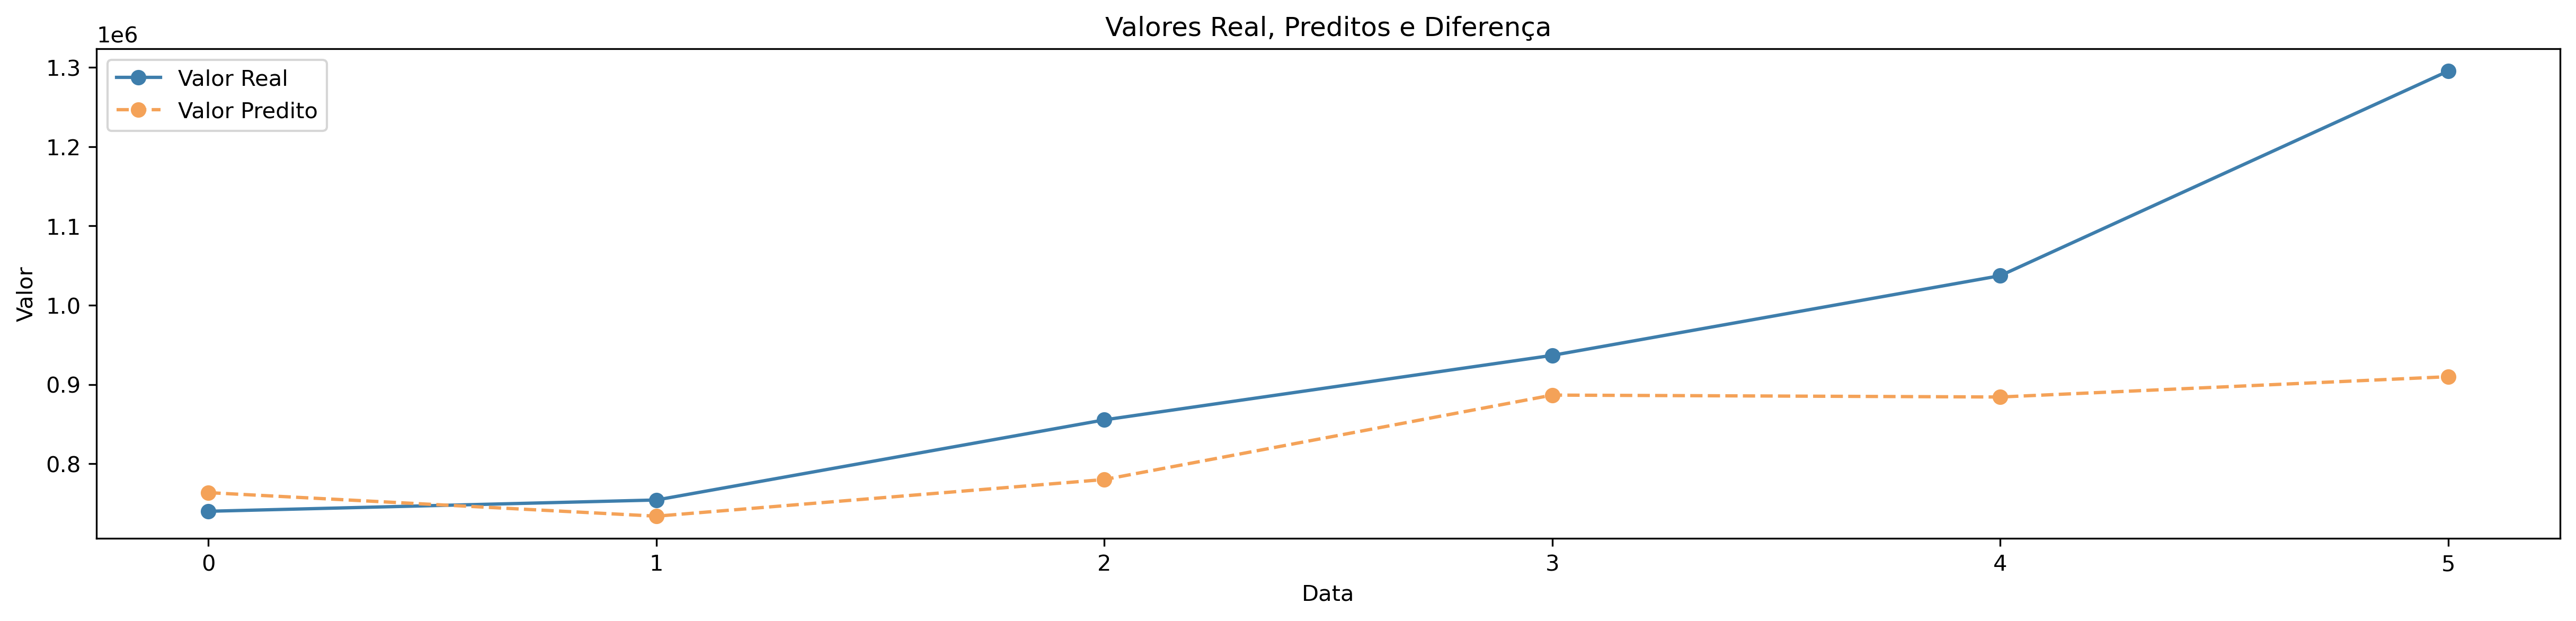

In [317]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras
--------------------------------------------------------------------------------------------------------------------
'''

# Coluna de diferença
df_resultados['Diferenca'] = df_resultados['Valor_Real'] - df_resultados['Valor_Predito']

plt.figure(figsize=(20, 4), dpi=300)
plt.plot(df_resultados.index, df_resultados['Valor_Real'], color='#3e7eac', label='Valor Real', marker='o')
plt.plot(df_resultados.index, df_resultados['Valor_Predito'], color='#f4a258', label='Valor Predito', marker='o', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real, Preditos e Diferença')
plt.legend()
plt.show()

# Loop por departamento

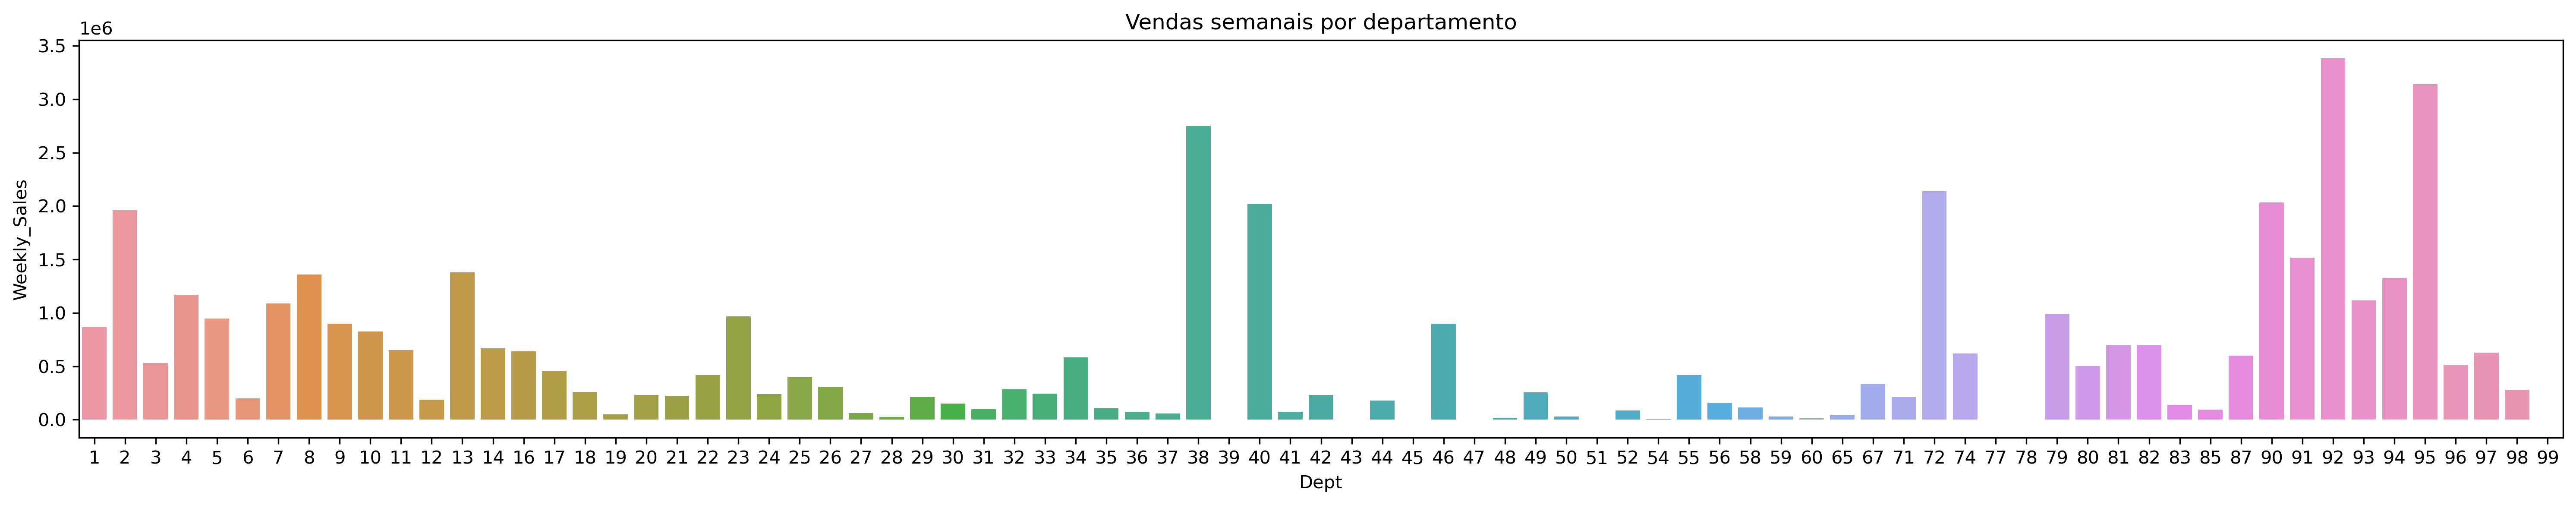

In [318]:
# Plotar um grafico de barras com o valor total das vendas de cada Dept
sales_by_dept = train_merge.groupby('Dept').resample('W')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(20, 4), dpi=300)
sns.barplot(data=sales_by_dept, x='Dept', y='Weekly_Sales', ci=None)
plt.title('Vendas semanais por departamento')
plt.tight_layout()

In [319]:
# Identificando quem são os departamento que a soma total da coluna Weekly_Sales é 0 
dept_zero = sales_by_dept[sales_by_dept['Weekly_Sales'] == 0]['Dept'].unique()

# Removendo os departamentos que a soma total da coluna Weekly_Sales é 0
train_merge = train_merge[~train_merge['Dept'].isin(dept_zero)]

# Total distinto de departamentos
print("Total de departamentos:", sales_by_dept['Dept'].nunique())
print("Total de departamentos eliminando vendas = 0", train_merge['Dept'].nunique())

Total de departamentos: 81
Total de departamentos eliminando vendas = 0 74


In [320]:
# Agora que os testes já foram feitos, ao invés de pegar apenas um departamento, vamos criar um loop por departamento
# e fazer o mesmo processo para todos os departamentos

'''
--------------------------------------------------------------------------------------------------------------------
-------- Loop para todos os departamentos
--------------------------------------------------------------------------------------------------------------------
'''

# Criando um DataFrame para armazenar os resultados
results_df = pd.DataFrame(columns=['Teste', 'Erro Total', 'RMSE', 'MAE', 'MAPE (%)'])

# Criando um DataFrame para armazenar os valores de forecast gerados
forecast_df = pd.DataFrame(columns=['Date', 'Forecast'])

# Armazenas os resultados das predições para cada um dos loops, considerar que cada departamento terá seu próprio tamanho de previsão
# Criar um dicionário vazio para armazenar as previsões
previsoes_departamentos = {}

# Loop pelos departamentos

for dept in train['Dept'].unique():
        
        dept_df = train_merge[train_merge['Dept'] == dept]
        dept_df = dept_df.drop(columns='Dept')
        
        # Criando as lags
        for i in range(6, 13):
            dept_df[f'lag{i}'] = dept_df.groupby('Store')['Weekly_Sales'].shift(i)
        
        # Separando as colunas definidas pelo Lasso
        dept_df = dept_df[colunas]
        dept_df = dept_df.dropna()
        
        # Separando as features e o target
        X = dept_df.drop(columns='Weekly_Sales')
        y = dept_df['Weekly_Sales']
        
        # Separando os dados de treino e teste
        X_train = X[X.index < '2012-09-21']
        y_train = y[y.index < '2012-09-21']
        X_test = X[X.index >= '2012-09-21']
        y_test = y[y.index >= '2012-09-21']

        # Hiperparâmetros
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        def objective(trial):
            
            # Espaço de hiperparâmetros para tunar
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 400), # quantidade de arvores 
                'max_depth': trial.suggest_int('max_depth', 3, 20), # profundidade da arvore
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3), # a cada iteração ele tenta diminuir o erro, e o intervalo indicado é o que eu espero
                'subsample': trial.suggest_uniform('subsample', 0.5, 1.0), # porcentagem de amostras que eu quero usar
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0), # porcentagem de colunas que eu quero usar
                'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1), # regularização L1 (diminuir overfitting)
                'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1), # regularização L2 (diminuir overfitting)
            }
            
            # Modelo
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
            
            # Predição e cálculo do RMSE
            preds = model.predict(X_test)
            rmse = mean_squared_error(y_test, preds, squared=False)
            
            return rmse

        # Criando o estudo
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=100)

        # Modelo default
        model = xgb.XGBRegressor(**study.best_trial.params)
        model.fit(X_train, y_train)

        # Predição
        predictions = model.predict(X_test)

        # Adicionando os valores gerados e validando os tamanhos de cada previsão, uma vez que cada uma das previsões terá tamanhos diferentes
        # Armazenar as previsões em um dataframe
        previsoes_dept = pd.DataFrame({
            'Data': X_test.index,
            'Dept': dept,
            'Previsao': predictions.flatten()
        })

        previsoes_departamentos[dept] = previsoes_dept

        # Erros
        if predictions.shape == y_test.shape:
            error = np.sum(predictions - y_test).round(2)
        else:
            error = 0

        if predictions.shape == y_test.shape:
            rmse = mean_squared_error(y_test, predictions, squared=False)
        else:
            rmse = 0

        if predictions.shape == y_test.shape:
            mae = mean_absolute_error(y_test, predictions)
        else:
            mae = 0

        if predictions.shape == y_test.shape:
            mape = mean_absolute_percentage_error(y_test, predictions)
        else:
            mape = 0
        
        # Adicionando os resultados ao DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({'Teste': [f'Dept {dept}'],
                                                          'Erro Total': [error],
                                                          'RMSE': [rmse],
                                                          'MAE': [mae],
                                                          'MAPE (%)': [mape]
                                                        })])

        print("Modelo do departamento", dept, "finalizado. MAPE (%):", mape)
        
# Exibir o DataFrame
results_df.sort_values(by='MAPE (%)')

Modelo do departamento 1 finalizado. MAPE (%): 13.823842930371011
Modelo do departamento 2 finalizado. MAPE (%): 6.64553221575103
Modelo do departamento 3 finalizado. MAPE (%): 67.24573334841192
Modelo do departamento 4 finalizado. MAPE (%): 7.618677993548056
Modelo do departamento 5 finalizado. MAPE (%): 29.94513428893693
Modelo do departamento 6 finalizado. MAPE (%): 110.46721240454862
Modelo do departamento 7 finalizado. MAPE (%): 36.15695994097798
Modelo do departamento 8 finalizado. MAPE (%): 5.278652583369223
Modelo do departamento 9 finalizado. MAPE (%): 153.2486251622452
Modelo do departamento 10 finalizado. MAPE (%): 23.971898027763007
Modelo do departamento 11 finalizado. MAPE (%): 28.028576180501396
Modelo do departamento 12 finalizado. MAPE (%): 19.934479681815155
Modelo do departamento 13 finalizado. MAPE (%): 6.215951186219459
Modelo do departamento 14 finalizado. MAPE (%): 24.99377244831199
Modelo do departamento 16 finalizado. MAPE (%): 1349.7602014837184
Modelo do depa

[W 2024-04-20 23:58:42,355] Trial 0 failed with parameters: {'n_estimators': 304, 'max_depth': 6, 'learning_rate': 0.003089375723292927, 'subsample': 0.6944046593953823, 'colsample_bytree': 0.8955491828751989, 'reg_alpha': 5.668040635231878, 'reg_lambda': 0.022339798608764786} because of the following error: ValueError('Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.').
Traceback (most recent call last):
  File "/Users/bentofh/anaconda3/envs/aprendendo_machine_learning/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/rl/s98bs4tx0390sxt66cbr96rm0000gn/T/ipykernel_13614/2398977351.py", line 67, in objective
    rmse = mean_squared_error(y_test, preds, squared=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bentofh/anaconda3/envs/aprendendo_machine_learning/lib/python3.11/site-packages/sklearn/metrics/_regres

Modelo do departamento 46 finalizado. MAPE (%): 12.169842703334398


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

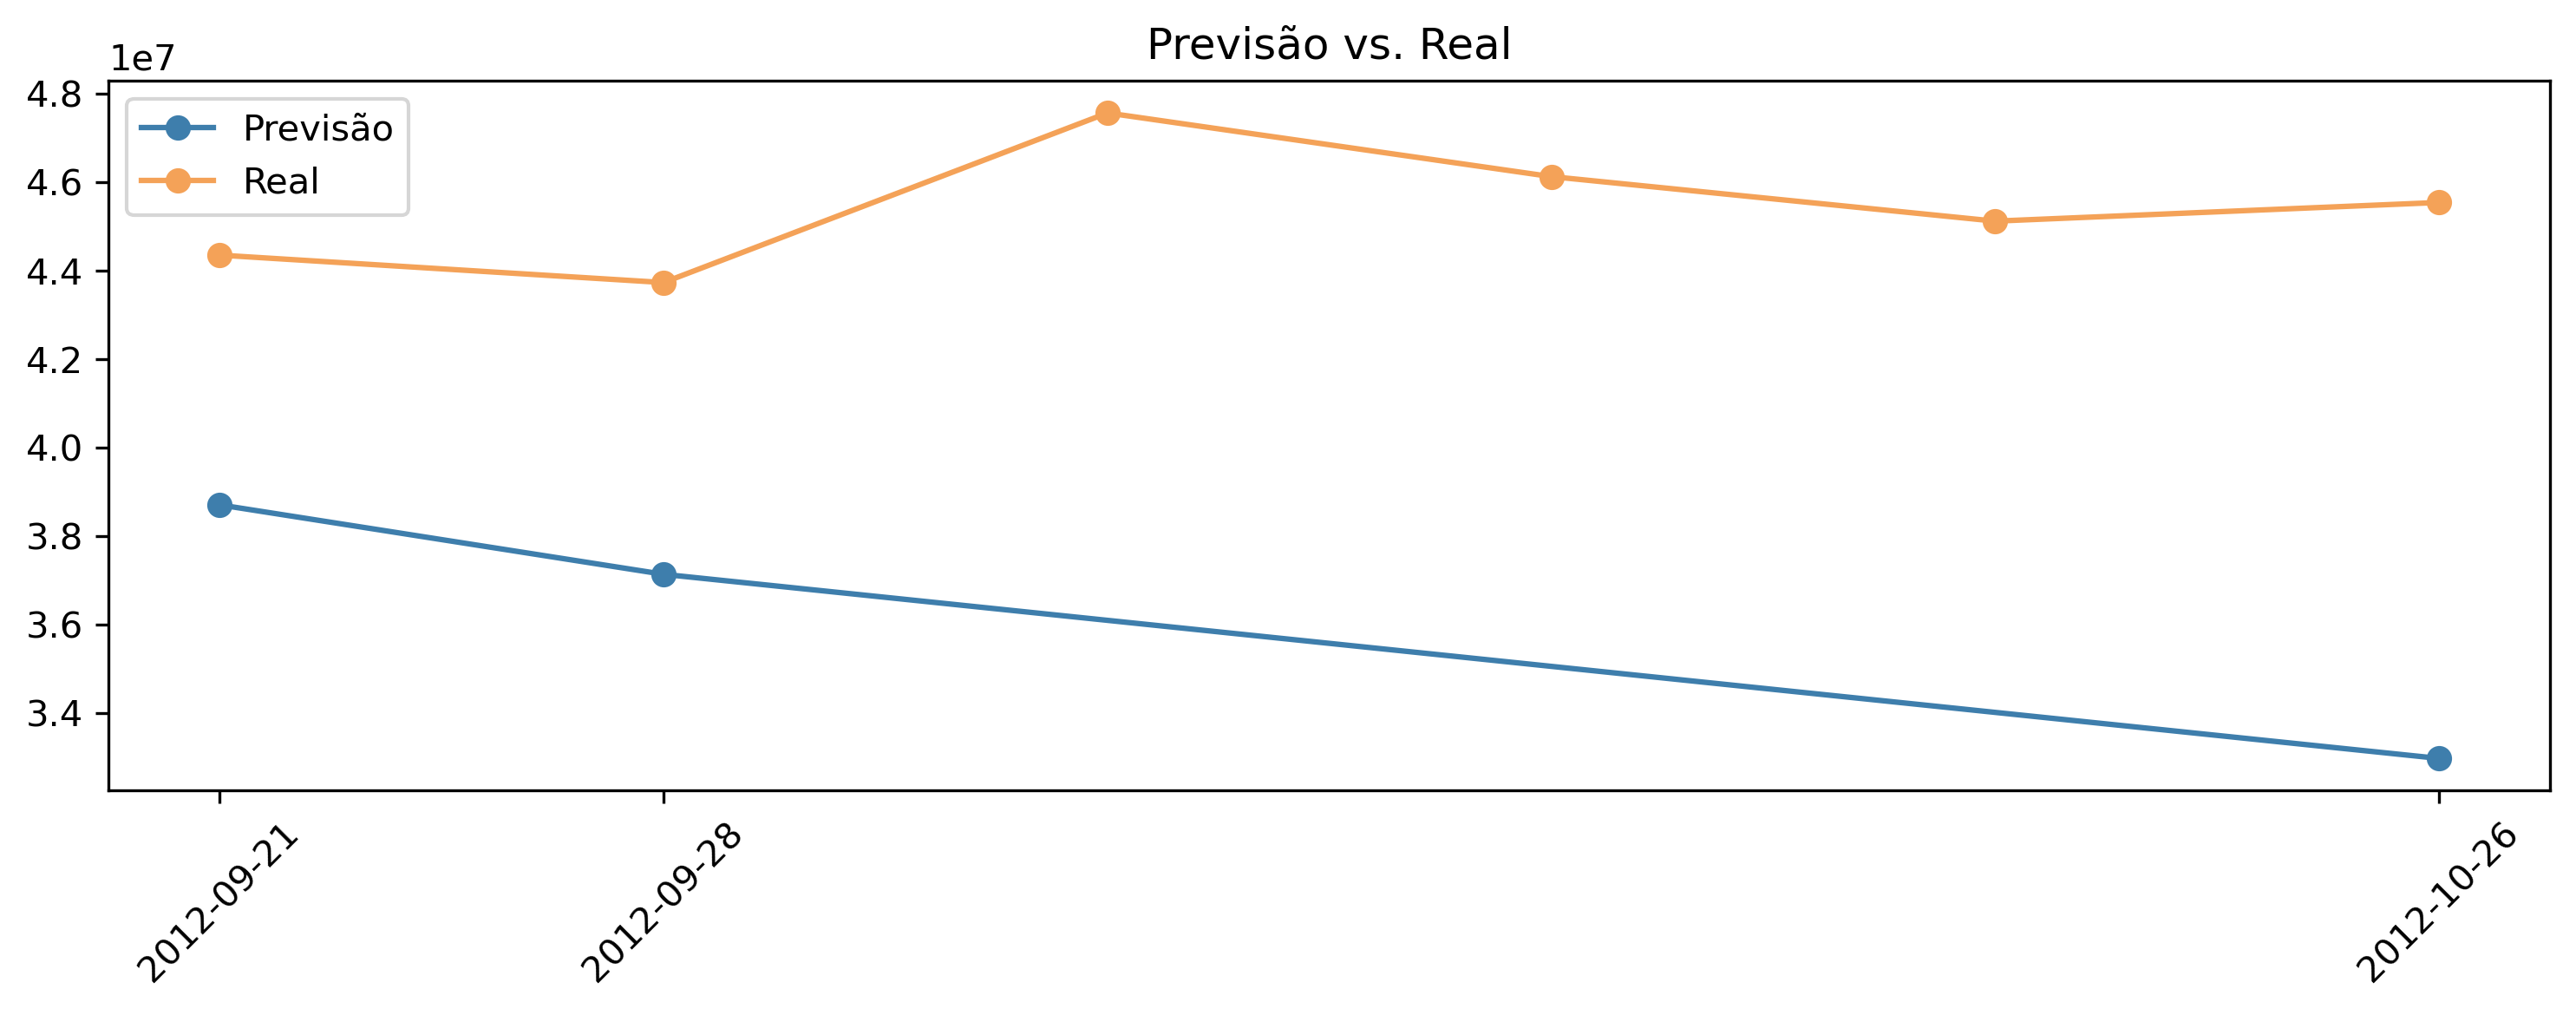

In [129]:
# Trasnformando a lista de resultados em dataframe
forecast_df = pd.concat(previsoes_departamentos.values())

# Unindo os resultados do forecast com os valores reais por data
forecast_groupby_date = forecast_df.groupby('Data')['Previsao'].sum().reset_index()

# Valores reais
sales_groupby_date = train_merge[train_merge.index >= '2012-09-21']
sales_groupby_date = sales_groupby_date.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Gráfico que compara os valores de Previsao e os valores reais
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(forecast_groupby_date['Data'], forecast_groupby_date['Previsao'], marker='o', linestyle='-', color='#3e7eac', label='Previsão')
plt.plot(sales_groupby_date['Date'], sales_groupby_date['Weekly_Sales'], marker='o', linestyle='-', color='#f4a258', label='Real')

plt.title('Previsão vs. Real')
plt.legend()
plt.xticks(forecast_groupby_date['Data'], rotation=45)
plt.tight_layout()
plt.show()